In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:

# Load preprocessed data
df = pd.read_csv("processed_data.csv")

In [6]:
# Define input features (including past NISLL)
features = df.columns.difference(["Patient", "Visite_date", "NISLL"]).tolist()
target = "NISLL"

In [9]:
# Normalize input features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [10]:
df[features]

,ExternalPoplitealSciaticMotorLeft_Foot_DorsalisPedis,ExternalPoplitealSciaticMotorRight_Foot_DorsalisPedis,Inotersen,InternalPoplitealSciaticMotorLeft_Ankle_CFPI,InternalPoplitealSciaticMotorRight_Ankle_CFPI,MedianDistalLatencyLeft,MedianDistalLatencyRight,MedianMotorLeft_Wrist_ThumbAbduction,MedianMotorRight_Wrist_ThumbAbduction,MedianSensoryLeft,...,RadialSensoryLeft,RadialSensoryRight,SuralSensitifD,SuralSensoryLeft,Tafamidis,UlnarMotorLeft_Wrist_FingerAdduction,UlnarMotorRight_Wrist_FingerAdduction,UlnarSensoryLeft,UlnarSensoryRight,Vutrisiran
0,0.211538,0.083695,0.0,0.139466,0.442211,0.426126,0.389431,0.535211,0.273917,0.061584,...,0.242609,0.221846,0.131757,0.166917,1.0,0.471506,0.522054,0.083558,0.084875,0.0
1,0.403846,0.071930,0.0,0.101695,0.427136,0.385818,0.326346,0.545689,0.503317,0.123167,...,0.312047,0.236646,0.236486,0.255639,1.0,0.559885,0.473956,0.196051,0.119718,0.0
2,0.126923,0.028947,0.0,0.110169,0.386935,0.458767,0.378882,0.419877,0.434815,0.080645,...,0.262273,0.176859,0.131757,0.131579,1.0,0.481333,0.411898,0.236953,0.174296,0.0
3,0.307692,0.024561,0.0,0.169492,0.452261,0.375686,0.323336,0.379780,0.358511,0.060117,...,0.217563,0.179883,0.202703,0.308271,1.0,0.505847,0.489031,0.112835,0.142606,0.0
4,0.211538,0.041228,0.0,0.149718,0.457286,0.457658,0.343089,0.500000,0.237875,0.080645,...,0.232938,0.215872,0.172297,0.161654,1.0,0.568966,0.664062,0.159379,0.128521,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.211538,0.192982,0.0,0.066384,0.125628,0.619820,0.437398,0.295775,0.281125,0.026686,...,0.111631,0.088067,0.000000,0.154135,1.0,0.413793,0.367188,0.062059,0.065141,0.0
438,0.201923,0.192982,0.0,0.059322,0.125628,0.574775,0.392683,0.176056,0.302750,0.020674,...,0.086011,0.118435,0.185811,0.086466,1.0,0.387931,0.343750,0.038082,0.040493,0.0
439,0.031731,0.166667,0.0,0.066384,0.042714,0.407979,0.398234,0.197156,0.161903,0.046921,...,0.082351,0.130930,0.000000,0.000000,0.0,0.326276,0.306497,0.010833,0.037235,0.0
440,0.122115,0.080702,0.0,0.059322,0.150754,0.252252,0.243089,0.352113,0.396458,0.074780,...,0.100651,0.081993,0.000000,0.090226,1.0,0.560345,0.437500,0.060649,0.000000,0.0


In [11]:
# Function to create sequences predicting the next available visit

def create_sequences(data, feature_cols, target_col):
    sequences,targets = [], []
    patients = data["Patient"].unique()

    for patient in patients:
        patient_data = data[data["Patient"] == patient].sort_values("Visite_date")
        num_visits = len(patient_data)

        for i in range(num_visits -1): # Stop at the second to last visit
            past_data = patient_data.iloc[:i+1][feature_cols].values      # All history up to visit i
            target_val = patient_data.iloc[i+1][target_col]               # Predict next visit's NISLL

            sequences.append(past_data)     
            targets.append(target_val)
    return sequences, np.array(targets)

In [21]:
# Create dataset (predicting NISLL at next visit)
X_list, y = create_sequences(df, features + ["NISLL"] , target)

In [ ]:
# Pad sequences to max length
X = pad_sequences(X_list, padding='pre', dtype='float32') # Pre-padding for LSTM

In [24]:
# SPlit train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Define LSTM model with masking (to handle variable length sequences)

model = Sequential([
    Masking(mask_value=0., input_shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True, activation="relu"),
    Dropout(0.2),
    LSTM(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1)  # Predicting NISLL at the next visit
])

In [26]:
# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])    

In [27]:
# Train model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
18/18 [==============================] - 4s 55ms/step - loss: 523.6315 - mae: 16.5299 - val_loss: 474.8788 - val_mae: 14.1552
Epoch 2/50
18/18 [==============================] - 0s 12ms/step - loss: 322.5731 - mae: 12.5346 - val_loss: 361.9804 - val_mae: 12.1045
Epoch 3/50
18/18 [==============================] - 0s 12ms/step - loss: 262.7721 - mae: 11.1447 - val_loss: 313.7546 - val_mae: 11.0620
Epoch 4/50
18/18 [==============================] - 0s 11ms/step - loss: 200.3515 - mae: 9.6497 - val_loss: 246.4654 - val_mae: 9.3556
Epoch 5/50
18/18 [==============================] - 0s 12ms/step - loss: 209.4243 - mae: 9.5327 - val_loss: 228.1704 - val_mae: 9.0576
Epoch 6/50
18/18 [==============================] - 0s 13ms/step - loss: 188.3174 - mae: 8.9339 - val_loss: 235.0633 - val_mae: 9.1217
Epoch 7/50
18/18 [==============================] - 0s 12ms/step - loss: 151.1437 - mae: 8.2966 - val_loss: 177.5217 - val_mae: 7.4331
Epoch 8/50
18/18 [==============================]

In [28]:
# Predict NISLL at next visits
predictions = model.predict(X_test)

3/3 [==============================] - 1s 5ms/step


In [29]:
# Print sample predictions
print("Sample Predictions:", predictions[:5])

Sample Predictions: [[ 3.4538276]
 [ 8.777998 ]
 [38.753544 ]
 [25.458786 ]
 [74.99505  ]]


In [32]:
# Add predicted NISLL scores back to the test set
predicted_nisll = predictions.flatten()  # Flatten the predictions array to match the number of test samples


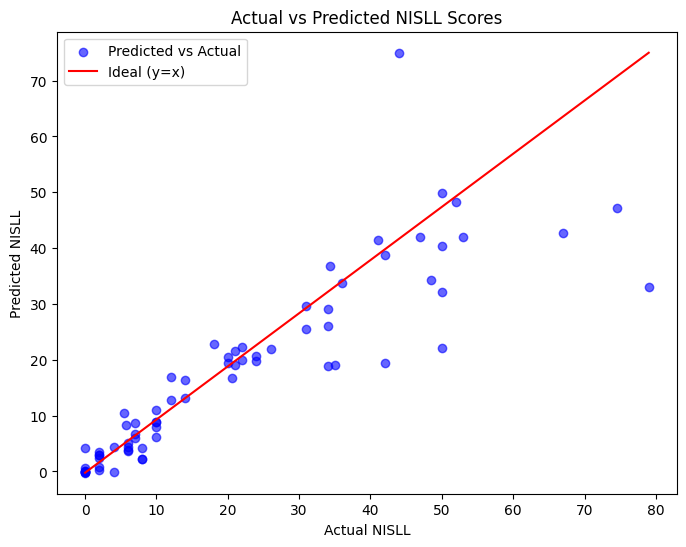

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot to visualize the comparison between predicted vs actual NISLL
plt.figure(figsize=(8, 6))

# Plotting actual vs predicted values
plt.scatter(y_test, predicted_nisll, alpha=0.6, color='blue', label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(predicted_nisll), max(predicted_nisll)], color="red", label="Ideal (y=x)")

# Labels and title
plt.title("Actual vs Predicted NISLL Scores")
plt.xlabel("Actual NISLL")
plt.ylabel("Predicted NISLL")
plt.legend()

# Show the plot
plt.show()

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your model is already trained and ready to make predictions

# Get historical data and predictions
predictions = []

for patient in df["Patient"].unique():
    # Filter the patient's data from the original DataFrame
    patient_data = df[df["Patient"] == patient].sort_values("Visite_date")

    # If the patient has data, make the prediction for the next visit
    if len(patient_data) > 1:  # Ensure there is at least one visit
        # Historical data (up to the last visit)
        historical_data = patient_data[["Visite_date", "NISLL"] + features].copy()

        # Get the last visit for the patient
        last_visit_data = patient_data.iloc[-1]

        # Make a prediction for the next visit using the model
        # (Assuming you have a method like model.predict() to get the prediction)
        next_visit_prediction = model.predict(np.array(np.concatenate([last_visit_data[features].values, [last_visit_data['NISLL']]]), dtype=np.float32).reshape(1, 1, -1))[0]

        predictions.append(next_visit_prediction)


1/1 [==============================] - 0s 20ms/step


In [66]:
# Convert predictions list to DataFrame
predictions_df = pd.DataFrame(predictions, columns=["Predicted_NISLL"])
print(predictions_df)

    Predicted_NISLL
0         15.912024
1         41.419407
2          0.105429
3         -0.034725
4         21.821470
..              ...
79        16.188848
80        44.959923
81         8.260207
82        18.288797
83         7.098695

[84 rows x 1 columns]


In [67]:
predictions_df['Predicted_NISLL'] = predictions_df['Predicted_NISLL'].apply(lambda x: 0 if x <= 0 else x)
print(predictions_df)

    Predicted_NISLL
0         15.912024
1         41.419407
2          0.105429
3          0.000000
4         21.821470
..              ...
79        16.188848
80        44.959923
81         8.260207
82        18.288797
83         7.098695

[84 rows x 1 columns]


In [71]:

# Assuming predictions_df contains the predicted NISLL values for each patient in order
# Initialize an empty list to store the combined data for each patient
combined_data = []

# Loop through each patient in df and get the corresponding prediction from predictions_df
for i, patient in enumerate(df["Patient"].unique()):
    # Filter the patient's historical data from the original DataFrame
    patient_data = df[df["Patient"] == patient].sort_values("Visite_date")

    # Retrieve the predicted NISLL for this patient from predictions_df (same order)
    predicted_nisll = predictions_df.iloc[i]['Predicted_NISLL']

    # Create a new DataFrame with historical NISLL data
    historical_data = patient_data[["Patient", "Visite_date", "NISLL"]].copy()

    # Append the predicted NISLL as the next visit for the patient
    # Add the predicted value as a new row (assuming 30 days after the last visit)
    next_visit_data = pd.DataFrame({
         "Patient": [patient],
        "Visite_date": [patient_data["Visite_date"].max() +180],  # Assuming the next visit is 30 days later
        "NISLL": [predicted_nisll]
    })

    # Append the next predicted visit to the historical data
    combined_patient_data = pd.concat([historical_data, next_visit_data], ignore_index=True)

    # Add the combined data for this patient to the list
    combined_data.append(combined_patient_data)

# Combine all patient data into a final DataFrame
final_df = pd.concat(combined_data, ignore_index=True)

# Check the final result
print(final_df.head())


  Patient  Visite_date      NISLL
0  C1S001            0  12.847826
1  C1S001          189   5.503235
2  C1S001          373  23.000000
3  C1S001          530  11.286869
4  C1S001          719   5.489362


In [72]:
final_df

,Patient,Visite_date,NISLL
0,C1S001,0,12.847826
1,C1S001,189,5.503235
2,C1S001,373,23.000000
3,C1S001,530,11.286869
4,C1S001,719,5.489362
...,...,...,...
521,C1S090,364,18.288797
522,C1S091,0,31.255567
523,C1S091,800,17.587677
524,C1S091,1717,8.000000


In [73]:
final_df['Patient'].nunique()

84